In [3]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def euclid_ccl(Omega_c, sigma8):

    cosmo_fid = ccl.Cosmology(Omega_c=Omega_c, Omega_b=0.045, h=0.71, sigma8=sigma8, n_s=0.963)
    nz = 1000
    z = np.linspace(0.0,3.,nz)
    pz = ccl.PhotoZGaussian(sigma_z0=0.05)
    dNdz_true = ccl.dNdzSmail(alpha = 1.3, beta = 1.5, z0=0.65)
    dNdzs = np.zeros((10, z.size))
    
    for i in range(10):
        zmin, zmax = i*0.2, (i+1)*.2
        dNdzs[i,:] = ccl.dNdz_tomog(z=z, zmin=zmin, zmax=zmax, pz_func=pz, dNdz_func = dNdz_true)
        # normalize each bin such that the integral is 1
        # Hu (1999) 
        dNdzs[i,:] /=  dNdzs[i,:].sum()
    
    #ell = np.arange(100,5000)
    ell = np.logspace(np.log10(100),np.log10(6000),10)
    shears = []
    for i in range(10):
        
        gal_shapes = ccl.WeakLensingTracer(cosmo_fid, dndz=(z, dNdzs[i,:]))
        shears.append(gal_shapes)
    
    Cls = []
    for i in range(10):
        for j in range(0,i+1):
            Cls.append(ccl.angular_cl(cosmo_fid, shears[i], shears[j], ell))
     
    return ell, np.array(Cls), dNdzs

In [15]:
%%time
ells, Cls, dNdzs = euclid_ccl(0.27, 0.82)
#ells, Cls_upper, dNdzs = euclid_ccl(0.29, 0.82)

CPU times: user 33 s, sys: 0 ns, total: 33 s
Wall time: 27.6 s


In [ ]:
%%time
for i in range(0,10):
    omega_c = 0.11 - i/100.
    print (omega_c)
    ells, Cls, dNdzs = euclid_ccl(omega_c, 0.82)

0.11


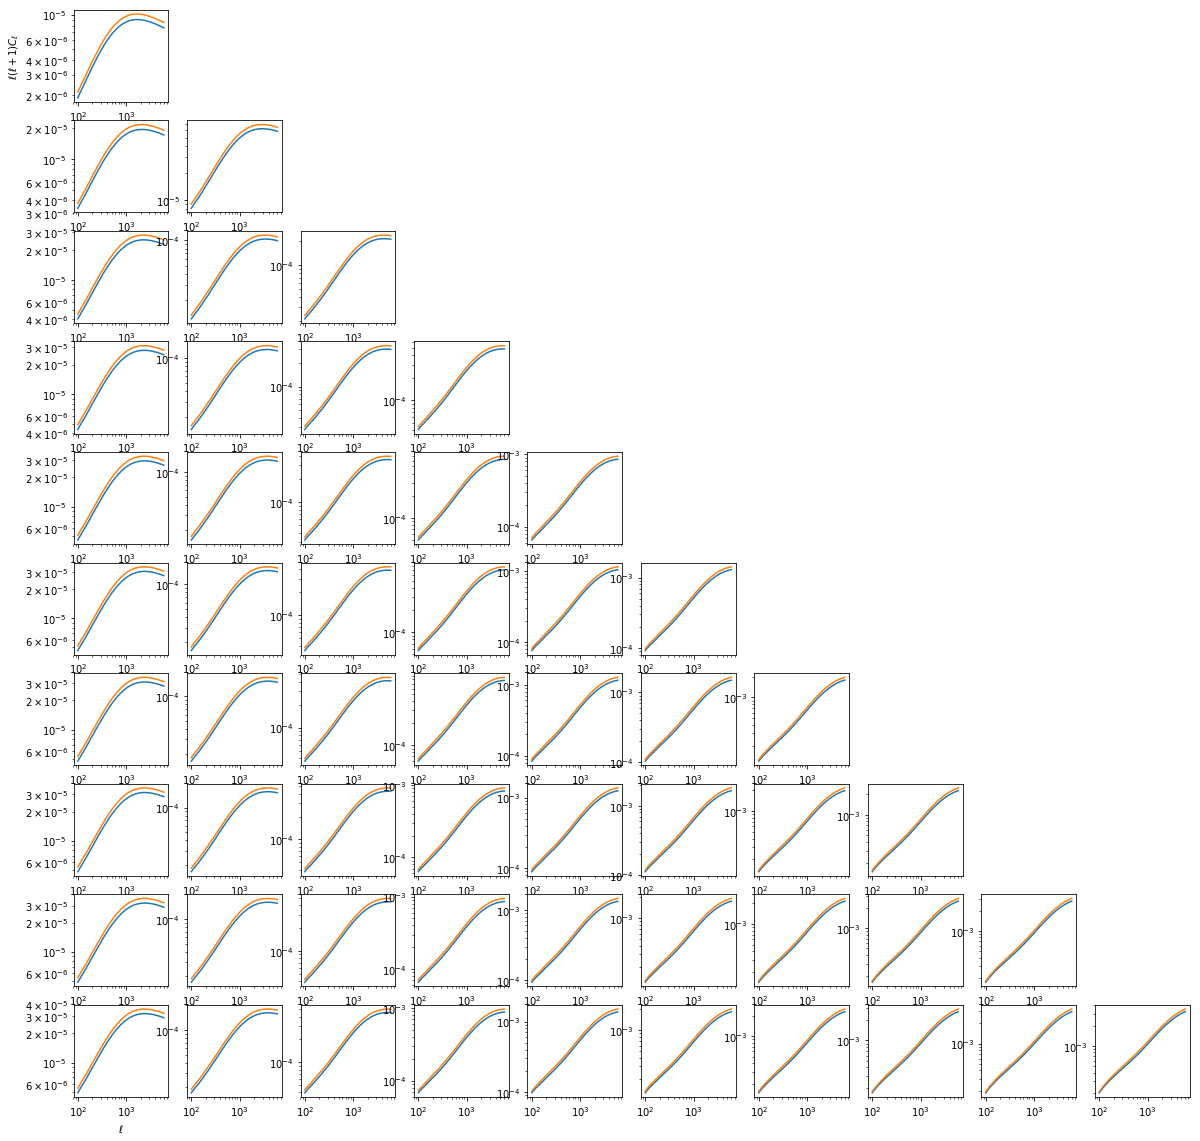

In [8]:
fig = plt.figure(figsize=(20,20))
counter = 0
for i in range(10):
        for j in range(0,i+1):
            ax = plt.subplot2grid((10,10), (i,j))
            ax.loglog(ells, ells*(ells+1)*Cls[counter])
            ax.loglog(ells, ells*(ells+1)*Cls_upper[counter])
            counter += 1
            
            if i == 0 and j == 0:
                ax.set_ylabel('$\ell  (\ell + 1) C_\ell$')
            if i == 9 and j == 0:
                ax.set_xlabel('$\ell$')
            

0.9999999999999999
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0000000000000002


Text(0.5, 0, 'z')

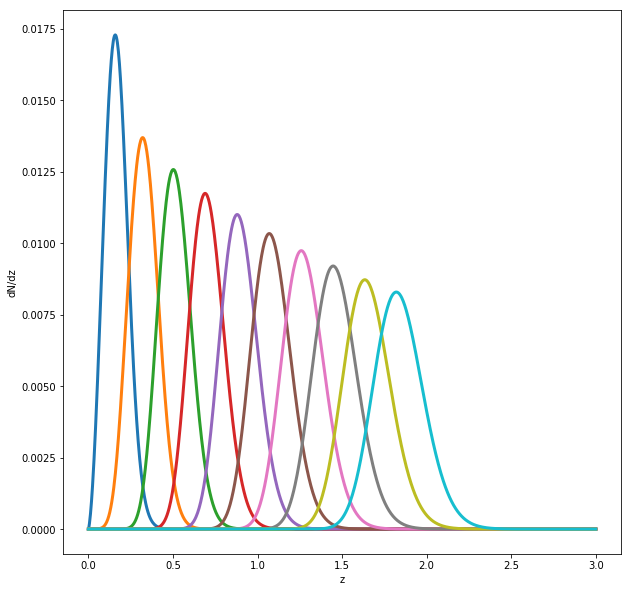

In [9]:
nz = 1000
z = np.linspace(0.0,3.,nz)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.plot(z, dNdzs[i,:], lw = 3)
    print (dNdzs[i,:].sum())
    
plt.ylabel('dN/dz')
plt.xlabel('z')

In [6]:
# bin the Cl's into Cb
def bin_Cl(ells, Cls, num_l_bins, fsky):
    """
    bin the Cls, which is an array of (55,len(ells)) into Cb
    which is an array of (55,num_l_bins) 
    
    Returns
    ell_bin_edges -- array of edges of the bins
    Cbs -- array of binned cross/auto power spectra

    """
    ell_bin_edges = np.logspace(np.log10(100), np.log10(6000), num_l_bins+1)
    ell_mins = ell_bin_edges[:-1]
    ell_maxs = ell_bin_edges[1:]

    # equation A10 in the HSC paper
    Pbl = ells**2 / (2*np.pi) # Conversion factor to the dimensionless power spectrum
    Pbl = np.ones(len(ells)) # put it on 1 for now so we don't convert to dimensionless
    Cbs = [] 
    for i in range(len(Cls)): # for every cross/auto spectrum
        C_b_i = []
        for b in range(0,num_l_bins): # bin the Cl
            mask = (ells>ell_mins[b])&(ells<ell_maxs[b])
            #Nmode_b = Modes_per_bin(b,ell_bin_edges, fsky)
            
            # number of modes per bin is just len(ells[mask])
            Nmode_b = len(ells[mask]) 
            C_b_i.append( 1/Nmode_b * np.sum( Pbl[mask] * Cls[i][mask] ) ) # then this just becomes the mean
        Cbs.append(C_b_i)
                         
    return ell_bin_edges, np.asarray(Cbs) #shape (55,num_l_bins)

    

In [7]:
def total_variance_Cls(i, j, m, n, nzs, ell_index, fsky, sn):
    '''fsky = fraction of sky, 15000/41252.96 for Euclid
    sn = shape noise = 0.3 ---> sn^2 = 0.3^2
    Cls = angular auto,cross power spectra
    nzs = array of number density values per tomographic bin
    '''
    ss_var_ij = (CL[i,m,ell_index]*CL[j,n,ell_index] + CL[i,n,ell_index]*CL[j,m,ell_index])/Modes_per_bin(ells[ell_index],fsky) 
    
    sn_var_ij = (CL[i,m,ell_index]*Nb_kroneker(j,n, sn) + Nb_kroneker(i,m, sn)*CL[j,n,ell_index] \
                 + CL[i,n,ell_index]*Nb_kroneker(m,j,sn) + Nb_kroneker(i,n,sn)*CL[m,j,ell_index])/Modes_per_bin(ells[ell_index],fsky)
    
    nn_var_ij = (Nb_kroneker(i,m,sn)*Nb_kroneker(j,n,sn) + Nb_kroneker(i,n,sn)*Nb_kroneker(j,m,sn))/Modes_per_bin(ells[ell_index],fsky) 
    
    return ss_var_ij + sn_var_ij + nn_var_ij


def total_covariance_Cbs(i, j, m, n, nzs, b, ell_bin_edges, fsky, sn):
    '''fsky = fraction of sky, 15000/41252.96 for Euclid
    INPUTS
    [i,j,m,n]     -- indices for tomographic bins
    nzs           -- array of number density values per tomographic bin
    b             -- index for ell bin 
    ell_bin_edges -- array defining edges of ells for b bins
    fksy          -- fraction of the sky
    sn            -- shape noise = 0.3 ---> sn^2 = 0.3^2
    
    ALSO NEEDS
    CB -- indexable power spectrum array [i,j,b]
    
    '''
    # reference to the paper, m = i' and n = j'
    
    N_eff_mode_b = Modes_per_bin(b, ell_bin_edges, fsky) # *w2^2/w4
    
    ss_var_ij = (CB[i,j,b]*CB[j,n,b] + CB[i,n,b]*CB[j,m,b])/N_eff_mode_b
    
    sn_var_ij = (CB[i,m,b]*Nb_kroneker(j,n, sn) + Nb_kroneker(i,m,sn)*CB[j,n,b] \
                 + CB[i,n,b]*Nb_kroneker(m,j,sn) + Nb_kroneker(i,n,sn)*CB[m,j,b])/N_eff_mode_b
    
    nn_var_ij = (Nb_kroneker(i,m,sn)*Nb_kroneker(j,n,sn) + Nb_kroneker(i,n,sn)*Nb_kroneker(j,m,sn))/N_eff_mode_b
    
    return ss_var_ij + sn_var_ij + nn_var_ij
    
def Modes_per_bin(b, ell_bin_edges, fsky):
    """
    Return the number of modes in the given l bin 'b'
    
    b -- int, label for the l bin
    ell_bin_edges -- array, edges of the l bins
    fsky -- float, fraction of the sky observed
    """
    
    # when binning, N_mode,b = fsky * (l_max_b^2 - l_min_b^2)
    lb_min = ell_bin_edges[b]
    lb_max = ell_bin_edges[b+1]
    
    return fsky * (lb_max**2 - lb_min**2)
    
def Nb_kroneker(i,j, sn):
    # shot noise spectrum, zero when i != j
    
    if i == j :
        x = sn/nzs[i]
        return x
    else:
        return 0

In [8]:
# bin the Cl's into Cb's, 10 bins
fsky = 15000./41252.96

ell_bin_edges, Cbs = bin_Cl(ells, Cls, 10, fsky)

# for indexing the C_b's, CB[i,j,b]
# i and j are tomographic indices b is ell bin index
CB = np.zeros((10,10, Cbs.shape[1]))
counter = 0
for i in range(10):
        for j in range(0,i+1):
            CB[i,j,:] = Cbs[counter]
            counter += 1
# symmetric
for i in range(10):
    for j in range(10):
        CB[i,j,:] = CB[j,i,:]

In [9]:
def euclid_nzs(num_dens):
    '''
    euclid num density = 30 arcmin^-2 = 108,000 deg^-2
    In steradians: A steradian is (180/π)^2 square degrees, or 3282.8 deg^2
    So Euclid number density 
    = 108,000 * 3282.8 = 354,543,086 galaxies per steradian
    
    '''
    nz = 1000
    zmin , zmax = 0., 3.
    z = np.linspace(zmin, zmax,nz)
    pz = ccl.PhotoZGaussian(sigma_z0=0.05)
    dNdz_true = ccl.dNdzSmail(alpha = 1.3, beta = 1.5, z0=0.65)
    dNdz_obs = ccl.dNdz_tomog(z=z, zmin=zmin, zmax=zmax, pz_func=pz, dNdz_func = dNdz_true)
    # scale to the given number density
    dNdz_obs = dNdz_obs/dNdz_obs.sum() * num_dens
    nzs = []
    for i in range(10):
        # calculate the number density of galaxies per steradian per bin
        zmin_i, zmax_i = i*.2 , (i+1)*.2
        mask = (z>zmin_i)&(z<zmax_i)
        nzs.append(dNdz_obs[mask].sum())
     
    return nzs

In [10]:
num_dens = 30 * 3600 * (180/np.pi)**2# from arcmin^-2 to deg^-2 to sr

# number density of the galaxies per steradian on the sky in the whole distribution ni(z)
nzs = euclid_nzs(num_dens) 
print (nzs)

[15129230.386022408, 48945249.76645687, 65515887.007072955, 66445008.63569144, 54672557.55110152, 40126917.951759696, 27153917.179162487, 16432829.882707924, 9560047.857406793, 5068906.003032466]


In [11]:
def covariance_Cb(b, ell_bin_edges):
    """
    Calculate the total Gaussian covariance as the sum of the three
    individual terms, for given bin number b. 
    
    Returns a (55,55) covariance matrix for given bin b
    """
    counter1 = 0
    counter2 = 0
    cov_Cb = np.zeros((55,55))
    for m in range(10):
            for n in range(0,m+1):
                counter2 = 0
                for i in range(10):
                        for j in range(0,i+1):
                            cov_Cb[counter1,counter2] = total_covariance_Cbs(i, j, m, n, nzs, b, ell_bin_edges, fsky, sn)
                            counter2 +=1
                counter1 += 1
                
    return cov_Cb


In [12]:
# calculate the covariance
sn = 0.3
cov_Cb_holder = []
for b in range(len(ell_bin_edges)-1):
    # calculate the covariance matrix for this bin b
    cov_Cb = np.array(covariance_Cb(b,ell_bin_edges))
    cov_Cb_holder.append(cov_Cb)
    
cov_Cb_holder = np.array(cov_Cb_holder) # shape (b,55,55)
# to keep a noise-free version of Cbs as well
Cbs_original = np.copy(Cbs)
    
# only have to repeat these lines to add noise
Cbs = np.copy(Cbs_original)
for b in range(len(ell_bin_edges)-1):
    # perturb Cb with noise
    Cbs[:,b] += np.random.multivariate_normal(np.zeros(cov_Cb_holder.shape[1]),cov_Cb_holder[b])
    



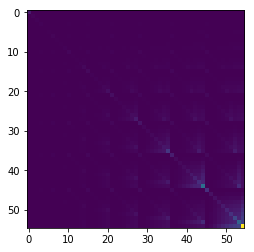

In [13]:
plt.imshow(cov_Cb_holder[0])

In [14]:
print (np.shape(cov_Cb_holder))
# check if matrix is symmetric
print (numpy.allclose(cov_Cb_holder[0], cov_Cb_holder[0].T, atol=np.min(cov_Cb_holder))) 
print (cov_Cb_holder[0][1,0], cov_Cb_holder[0][0,1])

print (Cbs[0][0])

(10, 55, 55)
False
2.2768347256388787e-21 2.280515446306476e-21
1.7733455828997887e-10


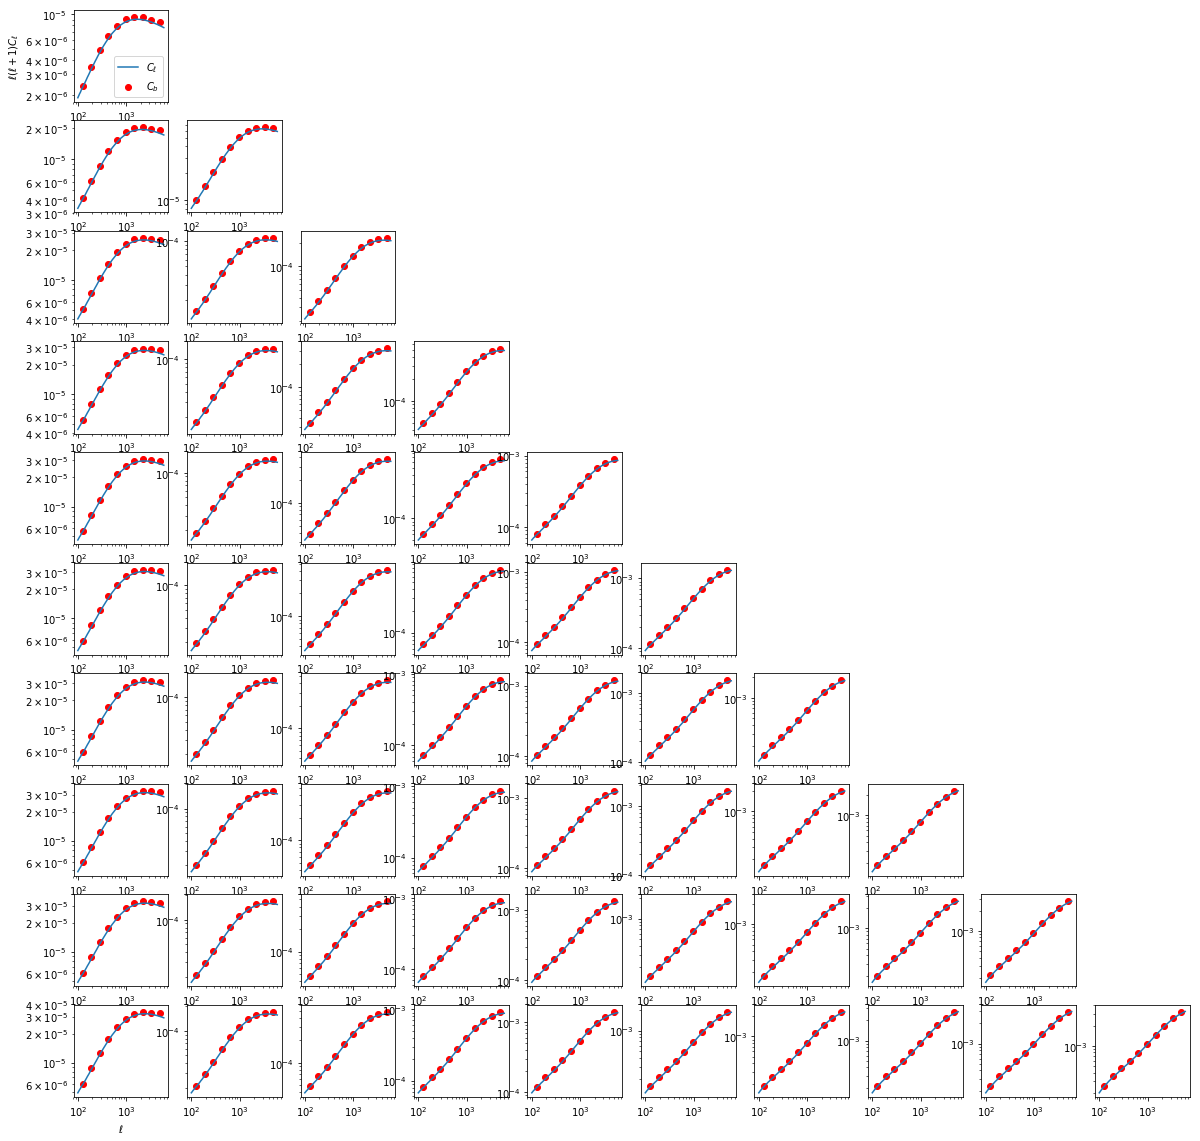

In [15]:
fig = plt.figure(figsize=(20,20))
counter = 0

ell_centers = .5*(ell_bin_edges[1:] + ell_bin_edges[:-1])

for i in range(10):
        for j in range(0,i+1):
            ax = plt.subplot2grid((10,10), (i,j))
            # plot Cl vs ell
            ax.loglog(ells, ells*(ells+1)*Cls[counter],label='$C_\ell$')
            # Plot Cb as well, as points centered on each bin
            ax.scatter(ell_centers,ell_centers*(ell_centers+1)*CB[i,j,:],color='r',label='$C_b$')
            
            #x.set_yscale('log')
            #x.set_xscale('log')
            if i == 0 and j == 0:
                ax.set_ylabel('$\ell  (\ell + 1) C_\ell$')
                ax.legend()
            if i == 9 and j == 0:
                ax.set_xlabel('$\ell$')
            
            counter += 1
            
plt.savefig('./cb_and_cl.png')

ValueError: operands could not be broadcast together with shapes (100,) (10,) 

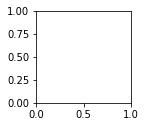

In [16]:
fig = plt.figure(figsize=(20,20))
counter = 0
bs = np.arange(0,len(ell_bin_edges)-1)
for i in range(10):
        for j in range(0,i+1):
            ax = plt.subplot2grid((10,10), (i,j))
            # plot Cl vs ell
            # plot error as 1 sigma errorbar, diagonal terms only
            onesigma = np.sqrt(cov_Cb_holder[:,counter,counter])
            ax.errorbar(ells, ells*(ells+1)*Cbs_original[counter], yerr=ells*(ells+1)*onesigma,fmt='-',lw=1)
            ax.set_yscale('log')
            ax.set_xscale('log')
            if i == 0 and j == 0:
                ax.set_ylabel('$\ell  (\ell + 1) C_\ell$')
            if i == 9 and j == 0:
                ax.set_xlabel('$\ell$')
            
            counter += 1
            
plt.savefig('./cb_errorbars.pdf')
plt.savefig('./cb_errorbars.png')

            

In [ ]:
i = 1
j = 1
counter = 2
fig, ax = plt.subplots(figsize=(20,20))
# plot Cl vs ell
# plot error as 1 sigma errorbar
onesigma = np.sqrt(cov_cl_holder[:,counter,counter])
print (np.max(cov_cl_holder[:,counter,counter]))
print (onesigma)
print (Cls_original[counter])
ax.errorbar(ells, ells*(ells+1)*Cls_original[counter], yerr=ells*(ells+1)*onesigma, fmt='-o', lw=1,label='original')
#ax.errorbar(ells, ells*(ells+1)*Cls[counter], yerr=0, fmt='-', lw=1, label='perturbed')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylim(10**-8,10**-2)
plt.legend(loc='upper left')

y1 = ells[0]*(ells[0]+1)*Cls_original[counter][0]
yer1 = ells[0]*(ells[0]+1)*onesigma[0]

In [ ]:
print ('Testing purposes')

In [ ]:
# repeat the story but split the 3 terms of the covariance
# to identify where it is going wrong

def total_variance_Cls_split(i, j, m, n, nzs, ell_index, fsky, sn):
    '''fsky = fraction of sky, 15000/41252.96 for Euclid
    sn = shape noise = 0.3 ---> sn^2 = 0.3^2
    Cls = angular auto,cross power spectra
    nzs = array of number density values per tomographic bin
    '''
    ss_var_ij = (CL[i,m,ell_index]*CL[j,n,ell_index] + CL[i,n,ell_index]*CL[j,m,ell_index])/Modes_per_bin(ells[ell_index],fsky) 
    
    sn_var_ij = (CL[i,m,ell_index]*Nb_kroneker(j,n, sn) + Nb_kroneker(i,m, sn)*CL[j,n,ell_index] \
                 + CL[i,n,ell_index]*Nb_kroneker(m,j,sn) + Nb_kroneker(i,n,sn)*CL[m,j,ell_index])/Modes_per_bin(ells[ell_index],fsky)
    
    nn_var_ij = (Nb_kroneker(i,m,sn)*Nb_kroneker(j,n,sn) + Nb_kroneker(i,n,sn)*Nb_kroneker(j,m,sn))/Modes_per_bin(ells[ell_index],fsky) 
    
    return ss_var_ij, sn_var_ij, nn_var_ij
    
def Modes_per_bin(ell,fsky):
    # when binning, fsky * (l_max_b^2 - l_min_b^2)
    return (2*ell+1)*fsky

def Nb_kroneker(i,j, sn):
    # shot noise spectrum, zero when i != j
    
    if i == j :
        x = sn/nzs[i]
        return x
    else:
        return 0


In [ ]:
# repeat the story but split the 3 terms of the covariance

def cov_cls_split(ell_index):
    counter1 = 0
    counter2 = 0
    cov_cl_SS = np.zeros((55,55))
    cov_cl_SN = np.zeros((55,55))
    cov_cl_NN = np.zeros((55,55))
    
    for m in range(10):
            for n in range(0,m+1):
                counter2 = 0
                for i in range(10):
                        for j in range(0,i+1):
                            cov_cl_SS[counter1,counter2], cov_cl_SN[counter1,counter2], cov_cl_NN[counter1,counter2] = total_variance_Cls_split(i, j, m, n, nzs, ell_index, fsky, sn)
                            counter2 +=1
                counter1 += 1
                
    return np.array(cov_cl_SS), np.array(cov_cl_SN), np.array(cov_cl_NN)

In [ ]:
# repeat the story but split the 3 terms of the covariance
cov_cl_holder_SS = []
cov_cl_holder_SN = []
cov_cl_holder_NN = []

for ell_index in range(len(ells)):
    # (55,55) arrays
    cov_cl_SS, cov_cl_SN, cov_cl_NN = cov_cls_split(ell_index)
    
    cov_cl_holder_SS.append(cov_cl_SS)
    cov_cl_holder_SN.append(cov_cl_SN)
    cov_cl_holder_NN.append(cov_cl_NN)
    
    
cov_cl_holder_SS = np.array(cov_cl_holder_SS)
cov_cl_holder_SN = np.array(cov_cl_holder_SN)
cov_cl_holder_NN = np.array(cov_cl_holder_NN)


In [ ]:
fig, axes = plt.subplots(3,1,figsize=(20,20))
cf = axes[0].imshow(cov_cl_holder_SS[0])
axes[0].set_title('SS')
fig.colorbar(cf, ax=axes[0])

cf = axes[1].imshow(cov_cl_holder_SN[0])
axes[1].set_title('SN')
fig.colorbar(cf, ax=axes[1])

cf = axes[2].imshow(cov_cl_holder_NN[0])
axes[2].set_title('NN')
fig.colorbar(cf, ax=axes[2])

In [ ]:
ell_index = 0
fig = plt.figure(figsize=(12,8))
plt.plot(np.diagonal(cov_cl_holder_SS[ell_index]),label='SS')
plt.plot(np.diagonal(cov_cl_holder_SN[ell_index]),label='SN')
plt.plot(np.diagonal(cov_cl_holder_NN[ell_index]),label='NN')
plt.xlabel('diagonal element index (x,x)')
plt.ylabel('value')
plt.yscale('log')
plt.title('Diagonal elements of covariance matrix, $\ell = $ %s'%str(ells[ell_index]))
plt.legend()
plt.savefig('./variances_separated.png')

